# Making image cutouts

This example notebook presents two example use cases for making cutouts out of Euclid images. Here is a quick overview of what will be covered:

1. **Making cutouts for sources from a source catalogue** - In this case the sources you want to make cutouts from are on different images. The images are not downloaded and the cutouts are made with the astroquery function Euclid.get_cutout. The steps are:

    * Step 1.1 Making the source catalogue query (or using your own file with sources)
    * Step 1.2 Making a single cutout
        * Getting the mosaic file name(s) that correspond(s) to source coordinates (ra, dec)
        * Choosing the best mosaic file to cut from (if there are multiple)
        * Making the cutout with the Euclid cutout service
        * Visualizing the cutout
    * Step 1.3. Making cutouts of all query results automatically
    * (Extra) Making cutouts with variable size depending on the size of the source
    * (Extra) Utilizing multithreading to make the cutouts faster
    <br/><br/>   
2. **Making cutouts from sources extracted from image with source extractor**  - In this case the sources you want to make cutouts from are all on the same image and you have the image available in datalabs (either uploaded or as a data volume). The sources are extracted and cutouts are made with the astropy method cutout2D. The steps are:
    * Step 2.1 Getting an example image
    * Step 2.2 Taking a look at the example image
    * Step 2.3 Extracting sources from a part of the image with the sep python package that is based on Source Extractor
    * Step 2.4 Making a cutout of one source
    * Step 2.5 Making a cutout of the full list of sources automatically
    
    
In general you should use the Astropy cutout method if you have the files downloaded or accessible on ESA Datalabs as a data volume and use the Euclid astroquery cutout method if you don't have the files (plan to access them on the archive anyway).

In [107]:
#the sep package is currently not part of euclid-tools so this pip install line needs to be run (and kernel restarted) once before running the notebook 
#%pip install --no-deps sep

**Installing necessary packages**

In [108]:
from astroquery.esa.euclid.core import EuclidClass, Euclid
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from multiprocessing.pool import ThreadPool
from astropy import wcs
from astropy.io import fits
import numpy as np
import pandas as pd
#import sep
import glob
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
plt.style.use(astropy_mpl_style)
pd.set_option('display.max_colwidth', 0) #to show full column content (no wrapping and no dots)

**Logging in**

In [222]:
# change to your username
Euclid.login(user='mwalms01')

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]


Password:  ········


INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


**Creating a folder to save all our future cutouts to**

In [112]:
#make a folder for the future cutouts
cutout_folder= './outputs/cutouts/'
if not os.path.exists(cutout_folder):
    os.makedirs(cutout_folder)

## 1. Making cutouts for sources from source catalogue query results

Use case: You query the source catalogue for sources and want to make cutouts for them

### Step 1.1 Making the query

As the first step we need something to make the cutouts from. For this we are making a query for some sources from the Euclid MER catalogue. This query can also be anything else you want to query instead. 

The query returns an astropy table that is converted to a pandas dataframe for better visualization. Each row in the result table corresponds to a file where the file_name column shows the name and file_path column the path. These are later used to access the file to make a cutout.

In [113]:
# source_df = pd.read_csv('combined_karina_strong_lens_classifications.csv', usecols=['id_str', 'target_ra', 'target_dec'])
# source_df

In [114]:
# need to query these with MER to get segmentation area for sizing

In [115]:
def cone_search(ra, dec):

    coord = SkyCoord(ra=ra, dec=dec, frame='icrs', unit="deg")
    radius = u.Quantity(0.5, u.deg)
    j = Euclid.cone_search(
        coordinate=coord, 
        radius=radius, 
        table_name="catalogue.mer_catalogue", 
        ra_column_name="right_ascension", 
        dec_column_name="declination", 
        columns="right_ascension, declination, object_id, segmentation_area", async_job=False)

    matches = j.get_results().to_pandas()
    return matches


# cone_search(source_df.iloc[0]['target_ra'], source_df.iloc[0]['target_dec'])

# cone_search(275, 75)  # deep
# cone_search(70, 50)  # wide


# seems to not actually be available on SAS?


In [223]:
# source_df = pd.DataFrame(data=[{'target_ra': 90.9854, 'target_dec': -35.9680}])  # desi lens


# source_df = pd.DataFrame(data=[{'target_ra': 69.323176, 'target_dec': -45.440704}])
# name = 'tiny_artifact'

# source_df = pd.DataFrame(data=[{'target_ra': 75.375663, 'target_dec': -42.226785}]) 
# name = 'y_only_a'

# source_df = pd.DataFrame(data=[{'target_ra': 74.058234, 'target_dec': -37.772512}]) 
# name = 'y_only_b'

# source_df = pd.DataFrame(data=[{'target_ra': 71.138347, 'target_dec': -41.870669}]) 
# name = 'y_only_c'

source_df = pd.DataFrame(data=[{'target_ra': 82.11167, 'target_dec': -47.764816}]) 
name = 'y_only_d'




In [224]:
        # r = source["kron_radius"] * 0.2 / 195 * u.arcmin

In [225]:
for i, source in source_df[:1].iterrows():
    print('Making cutout number:', str(i) + '/' + str(len(source_df)))
    
    ra = source["target_ra"]
    dec = source["target_dec"]

#     find the mosaic products which contain that source
# MW: the mosaic FOV query is not that obvious to me
# FoV is not null, and intersects is true (intersects=1)for:
# a circle (ICRS frame) centered on (ra, dec of source), with radius "0.5/60"), and
# the fov attribute of the mosaic (a polygon in ADQL format, I think)
# I don't really get the circle/radius part, but it seems like it might be a small radius circle intersecting the FoV polygon (and not just a point, as you might expect)
    query = "SELECT file_name, file_path, mosaic_product_oid, tile_index, instrument_name, filter_name, category, second_type, ra, dec, technique \
    FROM sedm.mosaic_product \
    WHERE (((mosaic_product.fov IS NOT NULL AND INTERSECTS(CIRCLE('ICRS'," + str(ra) + "," + str(dec)+","+ str(0.5/60) +"), mosaic_product.fov)=1))) \
    ORDER BY mosaic_product.tile_index ASC"
#     (instrument_name='VIS') AND
    job = Euclid.launch_job(query, verbose=False)

    if job is not None:
        mosaic_file_results_table = job.get_results()
        print(mosaic_file_results_table['filter_name'])
        
        #in the case of multiple returned mosaics (choosing best one)
        chosen_img_idx = 0
#         if len(mosaic_file_results_table) > 1:
#             source_coords = [(ra, dec)]
#             img_centre_coords = np.array(list(zip(mosaic_file_results_table['ra'], mosaic_file_results_table['dec'])))

#             dists = cdist(img_centre_coords, source_coords)
#             chosen_img_idx = np.argmin(dists)
        for chosen_img_idx in range(len(mosaic_file_results_table)):

            mosaic_file = mosaic_file_results_table[chosen_img_idx]

            #making the cutout
            c = SkyCoord(ra, dec, frame='icrs', unit="deg")
            r = .1 * u.arcmin  # TODO
            saved_cutout_filepath = Euclid.get_cutout(
                file_path=mosaic_file["file_path"] + "/" + mosaic_file["file_name"], 
                instrument=mosaic_file["instrument_name"], id=mosaic_file["tile_index"], 
                coordinate=c, radius=r, 
                # output_file=cutout_folder + 'cut{0}_{1}_{2}.fits'.format(str(i).zfill(3), str(round(ra, 3)), str(round(dec, 3))))
                output_file=cutout_folder + f'{name}_{mosaic_file["instrument_name"]}_{mosaic_file["filter_name"]}.fits')
            print("Cutout saved at", saved_cutout_filepath)

        # else:
        #     print("Could not find a file for source", str(i), "with coordinates:", str(ra), str(dec))


Making cutout number: 0/1
filter_name
-----------
      NIR_J
      NIR_H
        VIS
    DECAM_i
    DECAM_z
      NIR_Y
    DECAM_r
    DECAM_g
      NIR_H
    DECAM_r
      NIR_J
    DECAM_g
      NIR_Y
    DECAM_z
        VIS
    DECAM_i
Retrieving data.
Data request: TAPCLIENT=ASTROQUERY&FILEPATH=%2Fdata_03%2Frepository_otf%2FF-006%2FMER%2F102021525%2FNISP%2FEUC_MER_BGSUB-MOSAIC-NIR-J_TILE102021525-B1F7CF_20240310T191919.853557Z_00.00.fits&COLLECTION=NISP&OBSID=102021525&POS=CIRCLE%2C82.11167276750548%2C-47.76482112855181%2C0.0016666666666666668
------>https
host = easotf.esac.esa.int:443
context = /sas-cutout/cutout
Content-type = application/x-www-form-urlencoded
200 
Reading...
Done.
Cutout saved at ['./outputs/cutouts/y_only_d_NISP_NIR_J.fits']
Retrieving data.
Data request: TAPCLIENT=ASTROQUERY&FILEPATH=%2Fdata_03%2Frepository_otf%2FF-006%2FMER%2F102021525%2FNISP%2FEUC_MER_BGSUB-MOSAIC-NIR-H_TILE102021525-641AFE_20240310T191933.776180Z_00.00.fits&COLLECTION=NISP&OBSID=1020215

In [226]:
vis_loc = f'/media/home/team_workspaces/Galaxy-Zoo-Euclid/outputs/cutouts/{name}_VIS_VIS.fits'
y_loc = f'/media/home/team_workspaces/Galaxy-Zoo-Euclid/outputs/cutouts/{name}_NISP_NIR_Y.fits'
j_loc = f'/media/home/team_workspaces/Galaxy-Zoo-Euclid/outputs/cutouts/{name}_NISP_NIR_J.fits'
h_loc = f'/media/home/team_workspaces/Galaxy-Zoo-Euclid/outputs/cutouts/{name}_NISP_NIR_H.fits'

In [227]:
# !pip install -e .

In [228]:
from gz_euclid import cutout_utils
from gz_euclid import morphology_utils_ou_mer as m_utils

In [229]:
vis_cutout = fits.getdata(vis_loc)
y_cutout = fits.getdata(y_loc)
j_cutout = fits.getdata(j_loc)
# h_cutout = fits.getdata(h_loc)

In [230]:
vis_cutout, vis_header = fits.getdata(vis_loc, header=True)


In [231]:
# vis_header.values

(-0.5, 118.5, 118.5, -0.5)

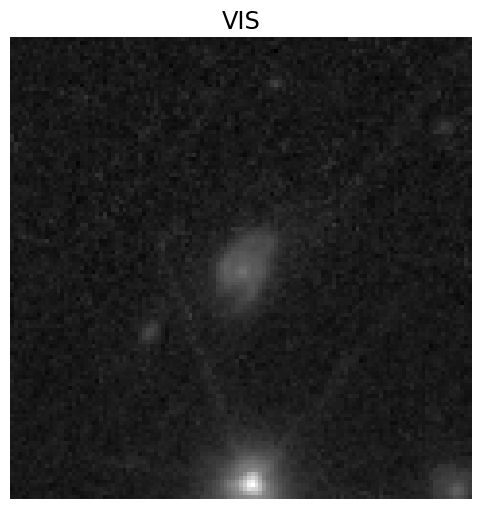

In [232]:
plt.imshow(np.arcsinh(vis_cutout * 100), cmap='gray')
plt.title('VIS')
plt.axis('off')

(-0.5, 118.5, 118.5, -0.5)

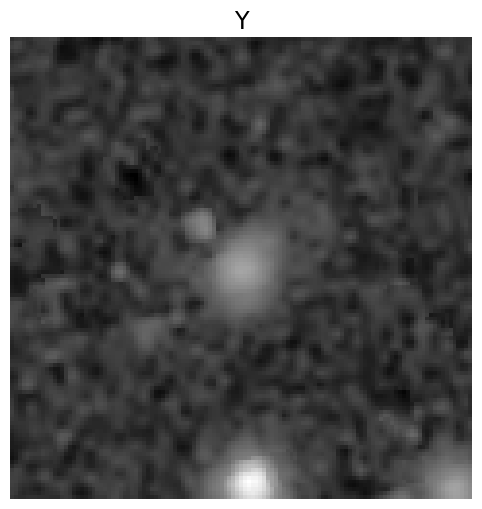

In [233]:
plt.imshow(np.arcsinh(y_cutout), cmap='gray')
plt.title('Y')
plt.axis('off')

(-0.5, 118.5, 118.5, -0.5)

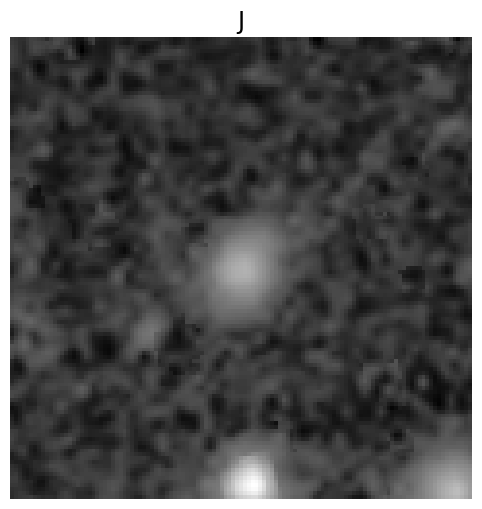

In [234]:
plt.imshow(np.arcsinh(j_cutout), cmap='gray')
plt.title('J')
plt.axis('off')

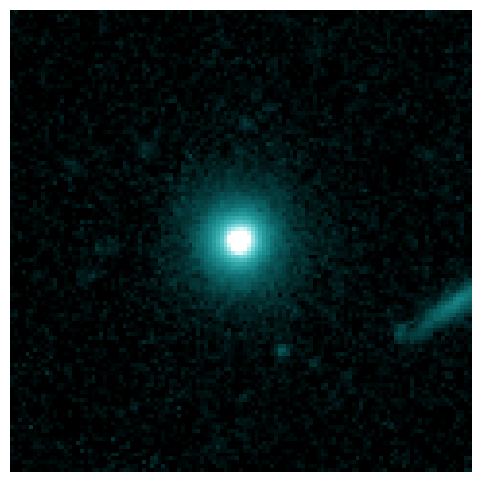

In [215]:
composite = cutout_utils.make_composite_cutout(vis_cutout, vis_cutout)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(composite, origin='lower')

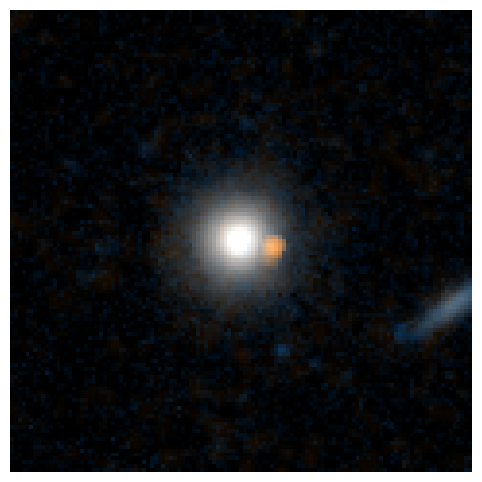

In [141]:
composite = cutout_utils.make_composite_cutout(vis_cutout, y_cutout)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(composite, origin='lower')

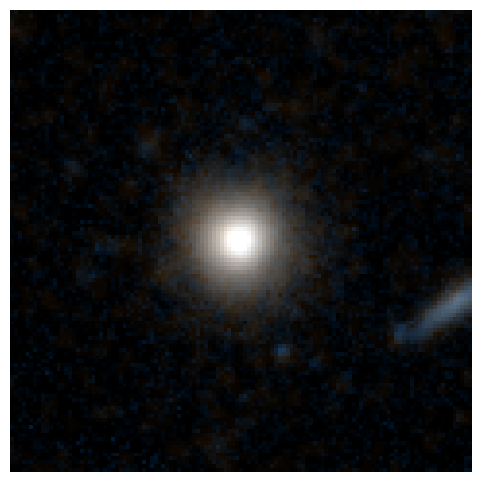

In [142]:
composite = cutout_utils.make_composite_cutout(vis_cutout, j_cutout)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(composite, origin='lower')

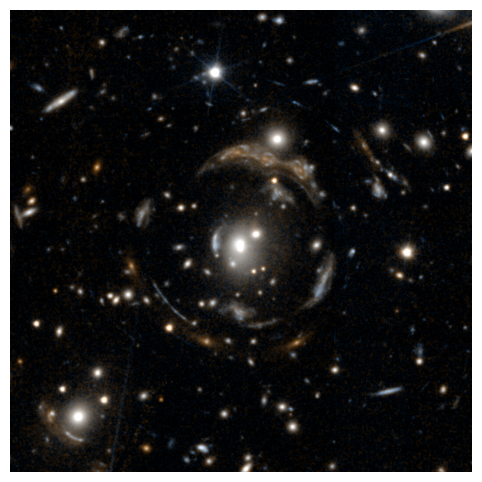

In [106]:
def make_composite_cutout(vis_cutout, nisp_cutout):
    # print('test complete')
    vis_flux_adjusted = m_utils.adjust_dynamic_range(vis_cutout, q=100, clip=99.85)
    # print('vis_flux_adjusted ready')
    nisp_flux_adjusted = m_utils.adjust_dynamic_range(nisp_cutout, q=.4, clip=99.85)

    mean_flux = np.mean([vis_flux_adjusted, nisp_flux_adjusted], axis=0)
    # print('mean ready')
    
    vis_uint8 = m_utils.to_uint8(vis_flux_adjusted)
    nisp_uint8 = m_utils.to_uint8(nisp_flux_adjusted)
    mean_flux_uint8 = m_utils.to_uint8(mean_flux)
    # print('uint8 ready')

    im = np.stack([nisp_uint8, mean_flux_uint8, vis_uint8], axis=2)
    # print('stack ready')
    return im

composite = make_composite_cutout(vis_cutout, y_cutout)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(composite, origin='lower')


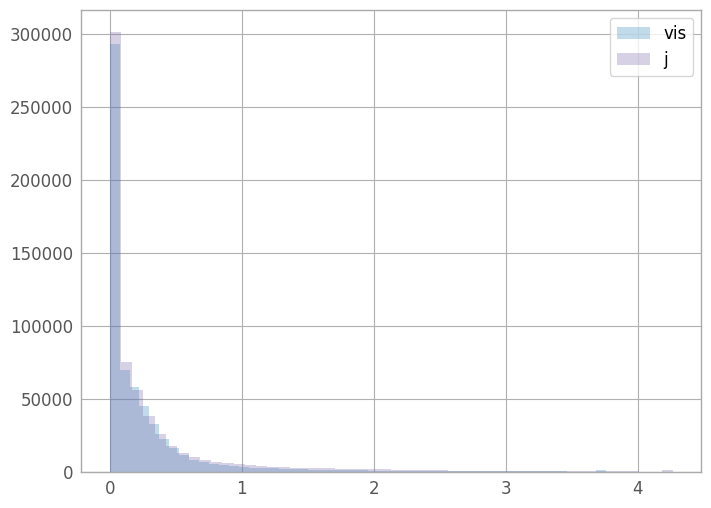

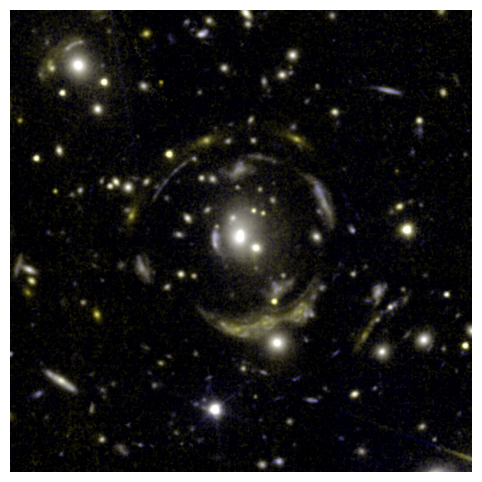

In [95]:
def make_triple_composite_cutout(vis_cutout, y_cutout, j_cutout):
    # print('starting composite')

    # assert vis_cutout.shape == y_cutout.shape, f'vis shape {vis_cutout.shape}, nisp shape {y_cutout.shape}'
    # assert vis_cutout.size < 19200**2, f'accidentally passed a whole tile, vis size {vis_cutout.size}'
    # assert vis_cutout.shape != (19200, 19200), f'accidentally passed a whole tile, vis size {vis_cutout.size}'
    # print(vis_cutout.shape)
    # print(vis_cutout.min(), vis_cutout.max())


    # print('test complete')
    vis_flux_adjusted = m_utils.adjust_dynamic_range(vis_cutout, q=100, clip=99.85)
    # print('vis_flux_adjusted ready')
    y_flux_adjusted = m_utils.adjust_dynamic_range(y_cutout, q=.4, clip=99.85)
    j_flux_adjusted = m_utils.adjust_dynamic_range(y_cutout, q=.45, clip=99.85)
    
    plt.hist(vis_flux_adjusted.flatten(), alpha=.3, label='vis', bins=50)
    # plt.hist(y_flux_adjusted.flatten(), alpha=.3, label='y', bins=50)
    plt.hist(j_flux_adjusted.flatten(), alpha=.3, label='j', bins=50)

    # mean_flux = np.mean([vis_flux_adjusted, nisp_flux_adjusted], axis=0)
    # print('mean ready')
    
    vis_uint8 = m_utils.to_uint8(vis_flux_adjusted)
    y_uint8 = m_utils.to_uint8(y_flux_adjusted)
    j_uint8 = m_utils.to_uint8(j_flux_adjusted)
    # mean_flux_uint8 = m_utils.to_uint8(mean_flux)
    # print('uint8 ready')
    plt.legend()

    im = np.stack([j_uint8, y_uint8, vis_uint8], axis=2)
    # print('stack ready')
    return im

composite = make_triple_composite_cutout(vis_cutout, y_cutout, j_cutout)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(composite)


**Visualizing the cutout with matplotlib**

Filename: ./outputs/cutouts/cut000_90.985_-35.968.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Original extension name    1 PrimaryHDU      43   (780, 780)   float32   
None


(-0.5, 779.5, -0.5, 779.5)

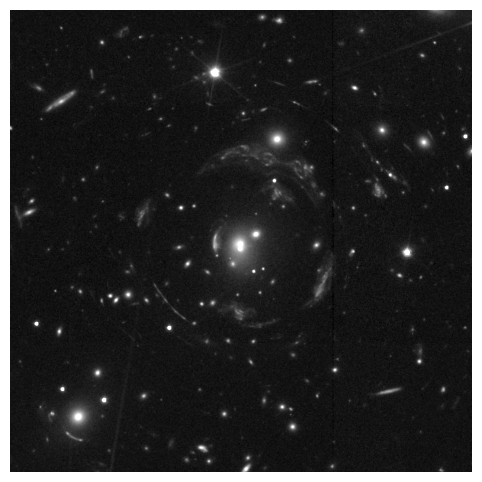

In [30]:
#viewing the cutout

saved_cutout_filepath = './outputs/cutouts/cut000_90.985_-35.968.fits'

hdul = fits.open(saved_cutout_filepath)
print(fits.info(saved_cutout_filepath))
image_data = hdul[0].data

# plt.figure()
fig, ax = plt.subplots()
ax.imshow(image_data, cmap='gray', origin='lower', norm=ImageNormalize(image_data, interval=PercentileInterval(99.8), stretch=AsinhStretch()))
# plt.grid('off')
ax.axis('off')
# colorbar = plt.colorbar()

In [ ]:
#showing 10 of the cutouts
files = sorted(glob.glob(cutout_folder + 'cut*.fits'))

_, axes = plt.subplots(2, 5, figsize=(25, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for ax, img_path in zip(axes.flatten(), files[:10]):
    image_data = fits.getdata(img_path, ext=0)
    ax.imshow(image_data, cmap='gray', origin='lower', norm=ImageNormalize(image_data, interval=PercentileInterval(99.9), stretch=AsinhStretch()))
    ax.axis("off")

### (Extra) Making cutouts with variable size depending on the size of the source 

In the example above all the cutouts have the same size/cutout radius of 0.2 arcminutes. In the next example we utilise the kron_radius parameter form the original table of sources and use that to scale the cutout radius.

(Note: for demo purposes we loop over only the first 10 `source_results_table[:10]`, this can be removed to loop over all sources in the initial table)

In [ ]:
#just for the first 10 sources in the table
for i, source in enumerate(source_results_table[10:20]):
    print('Making cutout number:', str(i) + '/' + str(len(source_results_table)))
    
    ra = source["right_ascension"]
    dec = source["declination"]

    query = "SELECT file_name, file_path, mosaic_product_oid, tile_index, instrument_name, filter_name, category, second_type, ra, dec, technique \
    FROM sedm.mosaic_product \
    WHERE (instrument_name='VIS') AND (((mosaic_product.fov IS NOT NULL AND INTERSECTS(CIRCLE('ICRS'," + str(ra) + "," + str(dec)+","+ str(0.5/60) +"), mosaic_product.fov)=1))) \
    ORDER BY mosaic_product.tile_index ASC"
    job = Euclid.launch_job(query, verbose=False)

    if job is not None:
        mosaic_file_results_table = job.get_results()
        
        #in the case of multiple returned mosaics (choosing best one)
        chosen_img_idx = 0
        if len(mosaic_file_results_table) > 1:
            source_coords = [(ra, dec)]
            img_centre_coords = np.array(list(zip(mosaic_file_results_table['ra'], mosaic_file_results_table['dec'])))

            dists = cdist(img_centre_coords, source_coords)
            chosen_img_idx = np.argmin(dists)
            
        mosaic_file = mosaic_file_results_table[chosen_img_idx]
        
        #making the cutout
        c = SkyCoord(ra, dec, frame='icrs', unit="deg")
        r = source["kron_radius"] * 0.2 / 195 * u.arcmin
        print("Coutout size is", r)
        saved_cutout_filepath = Euclid.get_cutout(file_path=mosaic_file["file_path"] + "/" + mosaic_file["file_name"], instrument=mosaic_file["instrument_name"], id=mosaic_file["tile_index"], coordinate=c, radius=r, output_file=cutout_folder + 'rad_cut{0}_{1}_{2}.fits'.format(str(i).zfill(3), str(round(ra, 3)), str(round(dec, 3))))
        print("Cutout saved at", saved_cutout_filepath)
        
    else:
        print("Could not find a file for source", str(i), "with coordinates:", str(ra), str(dec))
        

In [ ]:
#showing 10 of the cutouts
files = sorted(glob.glob(cutout_folder + 'rad_cut*.fits'))
print(files[:10])

_, axes = plt.subplots(2, 5, figsize=(25, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for ax, img_path in zip(axes.flatten(), files[:10]):
    image_data = fits.getdata(img_path, ext=0)
    ax.imshow(image_data, cmap='gray', origin='lower', norm=ImageNormalize(image_data, interval=PercentileInterval(99.9), stretch=AsinhStretch()))
    ax.axis("off")

### (Extra) Utilizing multithreading to make the cutouts faster 

In [ ]:
# def single_cutout(i, source):
    
#     ra = source["right_ascension"]
#     dec = source["declination"]

#     query = "SELECT file_name, file_path, mosaic_product_oid, tile_index, instrument_name, filter_name, category, second_type, ra, dec, technique \
#     FROM sedm.mosaic_product \
#     WHERE (instrument_name='VIS') AND (((mosaic_product.fov IS NOT NULL AND INTERSECTS(CIRCLE('ICRS'," + str(ra) + "," + str(dec)+","+ str(0.5/60) +"), mosaic_product.fov)=1))) \
#     ORDER BY mosaic_product.tile_index ASC"
#     job = Euclid.launch_job(query, verbose=False)

#     if job is not None:
#         mosaic_file_results_table = job.get_results()
        
#         #in case of multiple returned mosaics (choosing best one)
#         chosen_img_idx = 0
#         if len(mosaic_file_results_table) > 1:
#             source_coords = [(ra, dec)]
#             img_centre_coords = np.array(list(zip(mosaic_file_results_table['ra'], mosaic_file_results_table['dec'])))
#             dists = cdist(img_centre_coords, source_coords)
#             chosen_img_idx = np.argmin(dists)
            
#         mosaic_file = mosaic_file_results_table[chosen_img_idx]
        
#         #making the cutout
#         c = SkyCoord(ra, dec, frame='icrs', unit="deg")
#         r = 0.2 * u.arcmin
#         saved_cutout_filepath = Euclid.get_cutout(file_path=mosaic_file["file_path"] + "/" + mosaic_file["file_name"], instrument=mosaic_file["instrument_name"], id=mosaic_file["tile_index"], coordinate=c, radius=r, output_file=cutout_folder + 'multicut{0}_{1}_{2}.fits'.format(str(i).zfill(3), str(round(ra, 3)), str(round(dec, 3))))
#         print("Cutout", i, "saved at", saved_cutout_filepath)
        
#     else:
#         print("Could not find a file for source", str(i), "with coordinates:", str(ra), str(dec))
        
#     return True

# def multithread_cutout(num_processors, sources_table):
#     print("Preparing to make", len(sources_table), "cutouts")
#     pool = ThreadPool(num_processors)
#     input_data = [(i, row) for i, row in enumerate(sources_table[:10])]
#     results = pool.starmap(single_cutout, input_data)
#     return results

# results = multithread_cutout(2, source_results_table)

The result of the source extraction is 10 sources that correspond to the criteria that were set. The information about these sources is in `sources_thr` which is a numpy array containing 30 information fields for each source. One of these fields sontains information about the centre coordinates of each source which we will use to make cutouts in the next step.